In [63]:
# 📦 Стандартные библиотеки
import os
import json
import time
import random
from pathlib import Path

# 📊 Обработка и визуализация данных
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# 🤖 Машинное обучение (sklearn)
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 🔥 PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

# ⏳ Прогресс-бар
from tqdm import tqdm
import glob


In [64]:
# ----------------------------
# Device setup
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🛠 Device: {device}")

# ----------------------------
# Paths setup (UNIX style)
# ----------------------------

# 🔧 Вставь сюда свои актуальные пути:
DATA_ROOT = Path("/mnt/d/projects/wind_pressure_prediction_CNN/data/processed/cnn_input")
SAVE_ROOT = Path("/mnt/d/projects/wind_pressure_prediction_CNN/final_models/cnn_2e-04lr_64bs_ELU_16f")
CONFIG_PATH = Path("/mnt/d/projects/wind_pressure_prediction_CNN/final_models/cnn_2e-04lr_64bs_ELU_16f/cnn_2e-04lr_64bs_ELU_16f.json")
LOG_CSV_PATH = SAVE_ROOT / "stability_log.csv"

# ----------------------------
# Function to create a run-specific directory
# ----------------------------
def create_run_directory(
    run_name="cnn", lr=1e-3, batch_size=64, epochs=500,
    activation_fn=None, optimizer_name=None, base_dir=SAVE_ROOT
):
    run_id = f"{run_name}_{lr:.0e}lr_{batch_size}bs_{epochs}ep"
    
    if activation_fn is not None:
        run_id += f"_{activation_fn.__name__}"
    if optimizer_name is not None:
        run_id += f"_{optimizer_name}"
    
    run_dir = base_dir / run_id
    run_dir.mkdir(parents=True, exist_ok=True)

    print(f"📂 Created run directory: {run_dir}")
    return run_id, run_dir


🛠 Device: cpu


In [65]:
# ➤ Класс CNN-модели
class WindPressureCNN(nn.Module):
    def __init__(self, input_channels, filters, activation_fn, use_batchnorm):
        super(WindPressureCNN, self).__init__()

        layers = []
        in_channels = input_channels
        for out_channels in filters:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            if use_batchnorm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(activation_fn())
            in_channels = out_channels

        self.encoder = nn.Sequential(*layers)

        self.decoder = nn.Sequential(
            nn.Conv2d(filters[-1], filters[-2], kernel_size=3, padding=1),
            activation_fn(),
            nn.Conv2d(filters[-2], 1, kernel_size=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [66]:
# ➤ Пользовательский Dataset
class WindGridDataset(Dataset):
    def __init__(self, X_tensor, Y_tensor):
        self.X = X_tensor
        self.Y = Y_tensor

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# ➤ Оценка
def evaluate_regression(y_true, y_pred):
    y_true = y_true.detach().cpu().numpy().reshape(-1)
    y_pred = y_pred.detach().cpu().numpy().reshape(-1)
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return {
        "MSE": mean_squared_error(y_true[mask], y_pred[mask]),
        "MAE": mean_absolute_error(y_true[mask], y_pred[mask]),
        "R2": r2_score(y_true[mask], y_pred[mask])
    }

In [67]:
# ➤ Основная функция
def train_cnn(
    lr,
    batch_size,
    epochs,
    input_channels,
    activation_fn,
    optimizer_name,
    loss_fn,
    filters,
    use_batchnorm,
    run_id,
    X_train, Y_train,
    X_val, Y_val,
    best_r2
):
    # ⬇️ Переводим данные в тензоры
    X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
    Y_train = torch.tensor(Y_train, dtype=torch.float32).to(device)
    X_val   = torch.tensor(X_val,   dtype=torch.float32).to(device)
    Y_val   = torch.tensor(Y_val,   dtype=torch.float32).to(device)

    print("✅ Данные загружены в модель:")
    print("X_train shape:", X_train.shape)
    print("X_val shape:", X_val.shape)

    # 🎯 Проверка распределения целевой переменной
    plt.figure(figsize=(10, 5))
    plt.hist(Y_train.flatten(), bins=50, alpha=0.6, label='Train Y')
    plt.hist(Y_val.flatten(), bins=50, alpha=0.6, label='Val Y')
    plt.xlabel("Target Value")
    plt.ylabel("Frequency")
    plt.title(f"🎯 Target Distribution — Train vs Val")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    model = WindPressureCNN(
        input_channels=input_channels,
        filters=filters,
        activation_fn=activation_fn,
        use_batchnorm=use_batchnorm
    ).to(device)

    # Функция потерь
    criterion = loss_fn()

    # Оптимизатор
    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

    # Датасеты и загрузчики
    train_loader = DataLoader(WindGridDataset(X_train, Y_train), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(WindGridDataset(X_val, Y_val), batch_size=batch_size)

    # Тренировка
    best_loss = float("inf")
    patience = 5
    counter = 0

    for epoch in tqdm(range(epochs), desc="Epochs"):
        model.train()
        epoch_loss = 0.0
        for batch_X, batch_Y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_Y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Валидация каждые 100 эпох
        if (epoch + 1) % 100 == 0 or epoch == 0 or epoch == epochs - 1:
            model.eval()
            with torch.no_grad():
                y_val_pred = model(X_val)
                epoch_metrics = evaluate_regression(Y_val, y_val_pred)
                print(f"📉 Epoch {epoch + 1} | Train Loss: {epoch_loss:.6f} | "
                      f"Val R2: {epoch_metrics['R2']:.4f} | "
                      f"MAE: {epoch_metrics['MAE']:.4f} | "
                      f"MSE: {epoch_metrics['MSE']:.6f}")

        # Early Stopping
        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for batch_X, batch_Y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_Y)
                val_loss += loss.item()

        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("⏹️ Early stopping")
                break

    # Оценка на валидации (финал)
    model.eval()
    with torch.no_grad():
        y_pred = model(X_val)
        metrics = evaluate_regression(Y_val, y_pred)
        print(f"\n📈 Final Validation Metrics: {metrics}")

    if metrics["R2"] > best_r2:
        # Обновляем лучшую метрику
        best_r2 = metrics["R2"]
        
        # Удаляем все старые .pth в SAVE_ROOT
        for f in glob.glob(os.path.join(SAVE_ROOT, "*.pth")):
            os.remove(f)

        # Создаём красивое имя для сохранения весов
        filters_str = "-".join(map(str, filters))
        MODEL_FILENAME = (
        f"best_"
        f"{run_id}_"
        f"{activation_fn.__name__}_"
        f"{optimizer_name}.pth"
        )

        MODEL_SAVE_PATH = os.path.join(SAVE_ROOT, MODEL_FILENAME)

        # Сохраняем новые веса
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"💾 Сохранена новая лучшая модель: {MODEL_SAVE_PATH} (R² = {best_r2:.4f})")

    return model, metrics, best_r2
   



seeds: [594182, 536418]

🌱 Starting training with seed 594182
✅ Данные загружены в модель:
X_train shape: torch.Size([547, 3, 9, 28])
X_val shape: torch.Size([61, 3, 9, 28])


/tmp/ipykernel_45322/4287659794.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


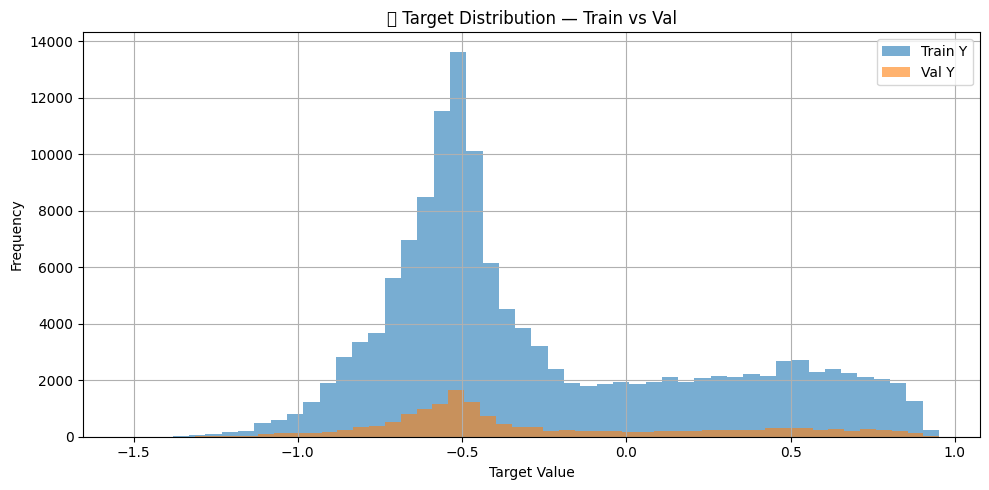

Epochs:   1%|          | 1/100 [00:05<09:13,  5.59s/it]

📉 Epoch 1 | Train Loss: 1.868135 | Val R2: -0.1865 | MAE: 0.5014 | MSE: 0.302146


Epochs:  25%|██▌       | 25/100 [01:02<03:08,  2.52s/it]

⏹️ Early stopping

📈 Final Validation Metrics: {'MSE': 0.02841651439666748, 'MAE': 0.12348423153162003, 'R2': 0.8884115815162659}
💾 Сохранена новая лучшая модель: /mnt/d/projects/wind_pressure_prediction_CNN/final_models/cnn_2e-04lr_64bs_ELU_16f/best_cnn_2e-04lr_64bs_ELU_16f_seed594182_ELU_Adam.pth (R² = 0.8884)
✅ Done: cnn_2e-04lr_64bs_ELU_16f_seed594182
📊 Metrics: R²=0.8884 | MSE=0.028417 | MAE=0.123484

🌱 Starting training with seed 536418
✅ Данные загружены в модель:
X_train shape: torch.Size([547, 3, 9, 28])
X_val shape: torch.Size([61, 3, 9, 28])



/tmp/ipykernel_45322/4287659794.py:36: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/mnt/d/projects/wind_pressure_prediction_CNN/environment/linux_wpp_cnn/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


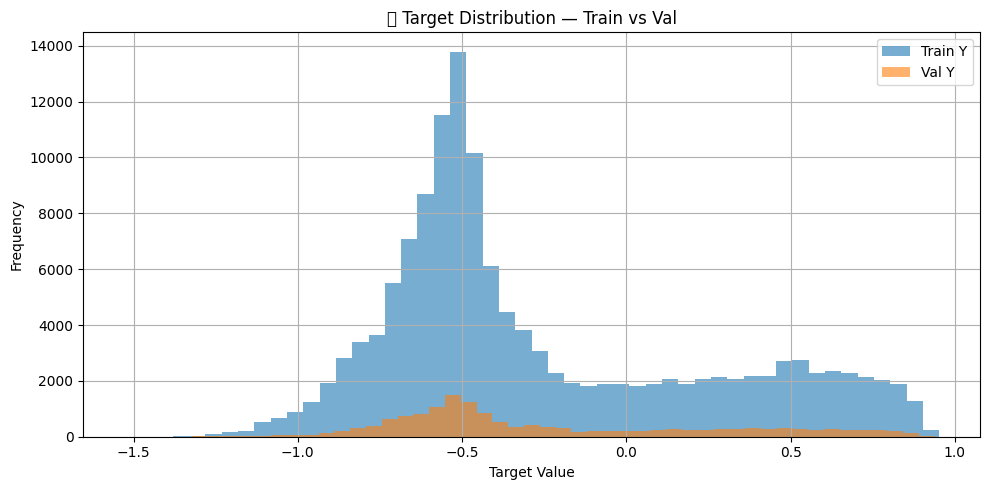

Epochs:   1%|          | 1/100 [00:02<03:30,  2.13s/it]

📉 Epoch 1 | Train Loss: 1.965903 | Val R2: -0.4558 | MAE: 0.5372 | MSE: 0.351274


Epochs:  44%|████▍     | 44/100 [01:30<01:55,  2.07s/it]

⏹️ Early stopping

📈 Final Validation Metrics: {'MSE': 0.027597805485129356, 'MAE': 0.1203637570142746, 'R2': 0.8856217861175537}
✅ Done: cnn_2e-04lr_64bs_ELU_16f_seed536418
📊 Metrics: R²=0.8856 | MSE=0.027598 | MAE=0.120364

🏆 Лучший запуск:
🆔 Run ID: cnn_2e-04lr_64bs_ELU_16f_seed594182
📈 R²: 0.8884
📉 MAE: 0.1235
📉 MSE: 0.028417


In [68]:
all_results = []

# === Установка сидов
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# === Загрузка данных и конфига
with open(CONFIG_PATH, "r") as f:
    config = json.load(f)

X_all = np.load(DATA_ROOT / "X_cnn.npy")
Y_all = np.load(DATA_ROOT / "Y_cnn.npy")

# === Цикл по сидом
NUM_RUNS = 2
random.seed(int(time.time()))  # или просто random.seed() для более случайной генерации
seeds = random.sample(range(1_000_000), NUM_RUNS)  # 10 уникальных случайных seed
base_run_id = CONFIG_PATH.parent.name
print('seeds:', seeds)

best_r2 = -np.inf

for seed in seeds:
    print(f"\n🌱 Starting training with seed {seed}")
    set_seed(seed)

    # 💡 Разбиение train/val с текущим сидом
    X_train, X_val, Y_train, Y_val = train_test_split(
        X_all, Y_all, test_size=0.1, random_state=seed
    )

    # 🔁 Создание новой копии конфига
    config_run = config.copy()
    run_id = f"{base_run_id}_seed{seed}"
    config_run["seed"] = seed
    config_run["run_id"] = run_id

    model, metrics, best_r2 = train_cnn(
        lr=config_run["lr"],
        batch_size=config_run["batch_size"],
        epochs=config_run["epochs"],
        input_channels=config_run["input_channels"],
        activation_fn=getattr(torch.nn, config_run["activation_fn"]),
        optimizer_name=config_run["optimizer"],
        loss_fn=getattr(torch.nn, config_run["loss_fn"]),
        filters=config_run["filters"],
        use_batchnorm=config_run["batchnorm"],
        run_id=run_id,
        X_train=X_train,
        Y_train=Y_train,
        X_val=X_val,
        Y_val=Y_val,
        best_r2 = best_r2
    )

    all_results.append({
        "run_id": run_id,
        "seed": seed,
        "R2": metrics["R2"],
        "MAE": metrics["MAE"],
        "MSE": metrics["MSE"]
    })

    print(f"✅ Done: {run_id}")
    print(f"📊 Metrics: R²={metrics['R2']:.4f} | MSE={metrics['MSE']:.6f} | MAE={metrics['MAE']:.6f}")

    # === Логирование в CSV
    log_header = "run_id,seed,lr,batch_size,activation_fn,optimizer,filters,R2,MAE,MSE\n"

    log_line = (
        f"{run_id},{seed},{config_run['lr']:.0e},{config_run['batch_size']},"
        f"{config_run['activation_fn']},{config_run['optimizer']},"
        f"\"{config_run['filters']}\",{metrics['R2']:.4f},{metrics['MAE']:.4f},{metrics['MSE']:.6f}\n"
    )

    # Создаём файл, если его ещё нет
    write_header = not os.path.exists(LOG_CSV_PATH)

    with open(LOG_CSV_PATH, "a") as f:
        if write_header:
            f.write(log_header)
        f.write(log_line)

# Найдём лучший результат
best_result = max(all_results, key=lambda x: x["R2"])

# Выводим
print("\n🏆 Лучший запуск:")
print(f"🆔 Run ID: {best_result['run_id']}")
print(f"📈 R²: {best_result['R2']:.4f}")
print(f"📉 MAE: {best_result['MAE']:.4f}")
print(f"📉 MSE: {best_result['MSE']:.6f}")


/tmp/ipykernel_45322/847303540.py:56: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_45322/847303540.py:56: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_45322/847303540.py:56: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_45322/847303540.py:57: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(fig_path)
/tmp/ipykernel_45322/847303540.py:57: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.savefig(fig_path)
/tmp/ipykernel_45322/847303540.py:57: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(fig_path)
/mnt/d/projects/wind_pressure_prediction_CNN/environment/linux_wpp_cnn/lib/python3.12/site-packages/IPython/core/py

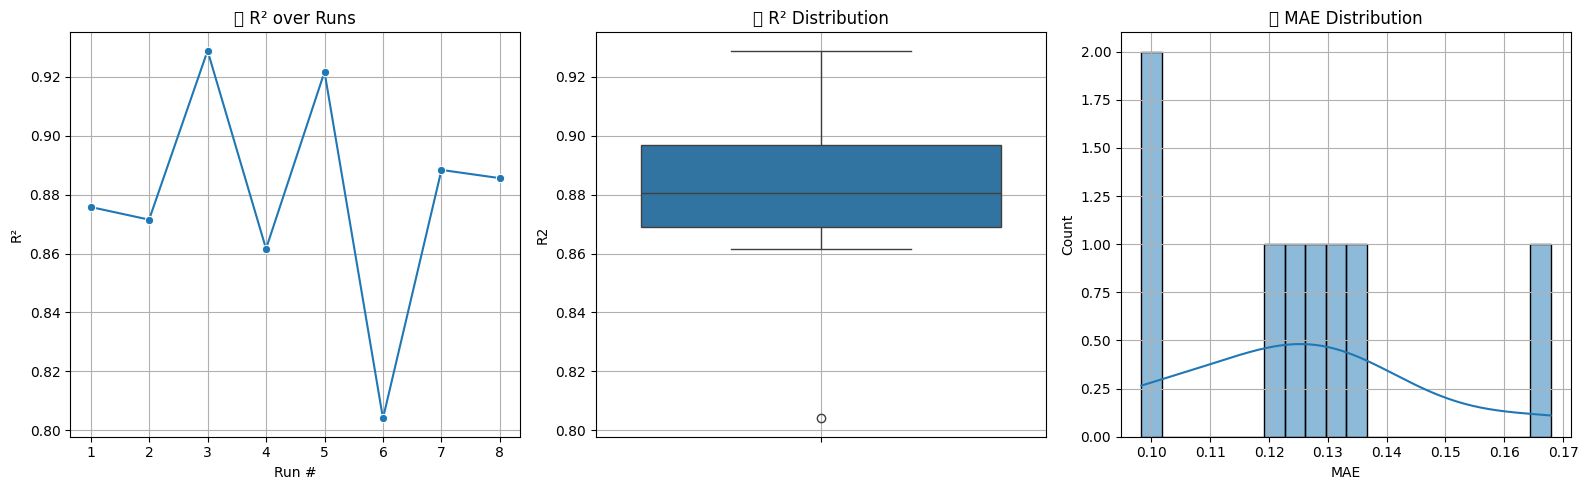

✅ Stability analysis complete:
{
    "R2_mean": 0.8797,
    "R2_std": 0.0386,
    "MAE_mean": 0.1254,
    "MAE_std": 0.022,
    "MSE_mean": 0.030075,
    "MSE_std": 0.009423,
    "runs": 8
}
📁 Saved metrics: /mnt/d/projects/wind_pressure_prediction_CNN/final_models/cnn_2e-04lr_64bs_ELU_16f/stability_cnn_2e-04lr_64bs_ELU_16f.json
🖼️  Saved plot: /mnt/d/projects/wind_pressure_prediction_CNN/final_models/cnn_2e-04lr_64bs_ELU_16f/stability_plot_cnn_2e-04lr_64bs_ELU_16f.png


In [69]:
# 📁 src/tuning/analyze_stability.py

# 📌 Пути (адаптируй под свой путь к лог-файлу)
SAVE_ROOT = Path("/mnt/d/projects/wind_pressure_prediction_CNN/final_models/cnn_2e-04lr_64bs_ELU_16f")
LOG_CSV_PATH = SAVE_ROOT / "stability_log.csv"
ARCH_LABEL = SAVE_ROOT.name  # используем имя папки как ярлык модели

# 📥 Загрузка результатов
df = pd.read_csv(LOG_CSV_PATH)

# ➕ Добавим колонку run по индексу
df["run"] = range(1, len(df) + 1)

# 📊 Подсчёт статистик стабильности
stability = {
    "R2_mean":  round(df["R2"].mean(), 4),
    "R2_std":   round(df["R2"].std(), 4),
    "MAE_mean": round(df["MAE"].mean(), 4),
    "MAE_std":  round(df["MAE"].std(), 4),
    "MSE_mean": round(df["MSE"].mean(), 6),
    "MSE_std":  round(df["MSE"].std(), 6),
    "runs": len(df)
}

# 💾 Сохраняем метрики
stability_path = SAVE_ROOT / f"stability_{ARCH_LABEL}.json"
with open(stability_path, "w") as f:
    json.dump(stability, f, indent=4)

# 📈 Визуализация
plt.figure(figsize=(16, 5))

# ➤ R² по прогонам
plt.subplot(1, 3, 1)
sns.lineplot(x="run", y="R2", data=df, marker="o", linewidth=1.5)
plt.title("📈 R² over Runs")
plt.xlabel("Run #")
plt.ylabel("R²")
plt.grid(True)

# ➤ Boxplot R²
plt.subplot(1, 3, 2)
sns.boxplot(y="R2", data=df)
plt.title("🎯 R² Distribution")
plt.grid(True)

# ➤ Гистограмма MAE
plt.subplot(1, 3, 3)
sns.histplot(df["MAE"], bins=20, kde=True)
plt.title("📉 MAE Distribution")
plt.xlabel("MAE")
plt.grid(True)

# 💾 Сохраняем график
fig_path = SAVE_ROOT / f"stability_plot_{ARCH_LABEL}.png"
plt.tight_layout()
plt.savefig(fig_path)
plt.show()

# ✅ Вывод
print("✅ Stability analysis complete:")
print(json.dumps(stability, indent=4))
print(f"📁 Saved metrics: {stability_path}")
print(f"🖼️  Saved plot: {fig_path}")
